In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Custom Class for handling backpropagation (scalar equivalent of Pytorch Tensor)

In [42]:
# Create a class to wrap a scaler with operations for back propagation
class Value:
  def __init__(self, data, _children=(), _op='', label=""):
    self.data = data
    self.label = label
    self._prev = set(_children)
    self.grad = 0.0
    self._op = _op
    self._backward = lambda: None


  def __repr__(self):
    return f"data={self.data}"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    # Derivative of 2 terms added
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    # Assign backward of output to current backward func
    out._backward = _backward

    return out


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self,other), '*')

    # Derivative of 2 terms multiplied
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    # Assign backward of output to current backward func
    out._backward = _backward

    return out

  def __sub__(self, other):
    return self + -other

  def __truediv__(self, other):
    return self * other**-1

  def __pow__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data ** other.data, (self,other), '**')

    # Derivitive of power
    def _backward():
      self.grad += other.data*self.data**(other.data-1) * out.grad
    # Assign backward of output to current backward func
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def __rsub__(self, other):
    return other + (-self)

  def __rtruediv__(self, other):
    return other * self**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    # Initiate empty list for storing tology
    topo = []
    # Initiate empty set for visted nodes
    visit = set()
    # Create a function for going over nodes unvisited nodes and adding to visited set and topology
    def build_topo(v):
      if v not in visit:
        visit.add(v) # Add to visit set if input node is unvisited
        for child in v._prev: # Add children nodes to visit set and topology first
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # Initiate first gradient value to 1.0
    self.grad = 1.0

    # Reverse the topology order, since we're doing backpropagation
    for node in reversed(topo):
      node._backward() # Calls the backward function in each operation



## Functions for DAG visualization

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [8]:
# Example operations

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

data=-8.0

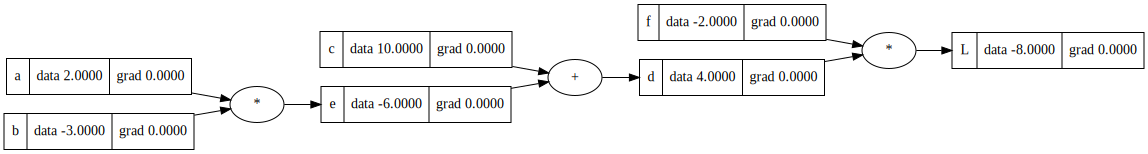

In [9]:
draw_dot(L)

## Manual Backpropagation on scalars

In [10]:
# Initialize gradient of output to 1
L.grad = 1

In [11]:
# dL/dd
d.grad = f.data * L.grad

# dL/df
f.grad = d.data * L.grad

In [12]:
# dL/dc = dL/dd * dd/dc
c.grad = d.grad * 1

# dL/de = dL/dd * dd/de
e.grad = d.grad * 1

In [13]:
# dL/da = dL/de * de/da
a.grad = e.grad * b.data

# dL/db = dL/de * de/db
b.grad = e.grad * a.data

## Manual backpropagation on a neuron

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o

data=0.7071067811865476

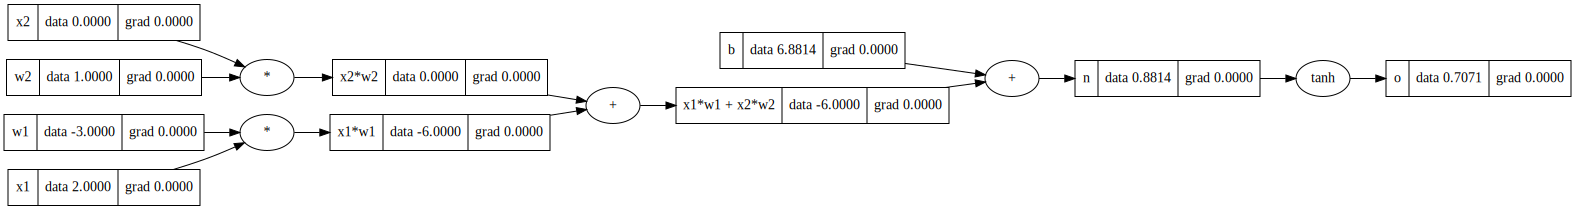

In [15]:
draw_dot(o)

In [16]:
# Initialize output gradient to 1
o.grad = 1

# do/dn = 1 - (tanh x)**2
n.grad = o.grad * (1 - o.data**2)

# do/db = do/dn * dn/db
b.grad = n.grad * 1.0

# do/d(x1w1+x2w2) = do/dn * 1
x1w1x2w2.grad = n.grad * 1.0

# do/d(x1w1) = do/d(x1w1x2w2) * 1.0
x1w1.grad = x1w1x2w2.grad * 1.0

# do/d(x2w2) = do/d(x1w1x2w2) * 1.0
x2w2.grad = x1w1x2w2.grad * 1.0

# do/dx1 = do/d(x1w1) * w1
x1.grad = x1w1.grad * w1.data

# do/w1 = do/d(x1w1) * x1
w1.grad = x1w1.grad * x1.data

# do/x2 = do/d(x2w2) * w2
x2.grad = x2w2.grad * w2.data

# do/w2 = do/d(x2w2) * x2
w2.grad = x2w2.grad * x2.data


## Automatic gradient after adding backward function in Class

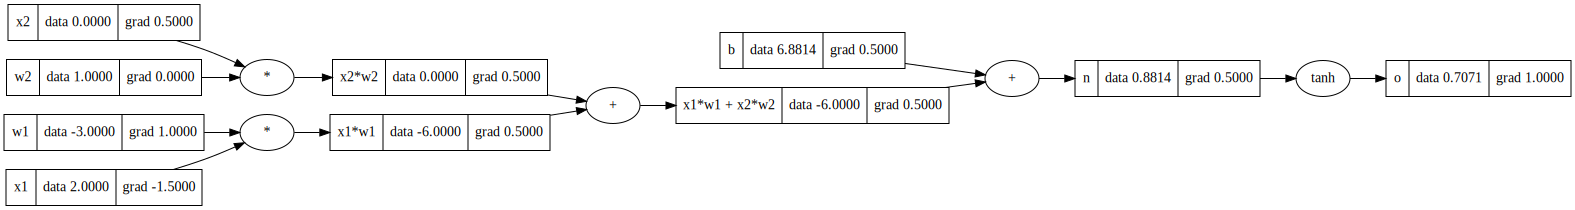

In [17]:
draw_dot(o)

In [18]:
o.backward()

## Perform the same on PyTorch

In [19]:
import torch
# Defining scalars on PyTorch tensors

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Implement a Neural Network Class (Like PyTorch)

In [109]:
import random

class Neuron:

  def __init__(self, nin, nonlin=True):
    # Initialize list of random weights between -1 and 1 for every input
    self.weight = [Value(random.uniform(-1,1)) for _ in range(nin)]

    # Initialize a single bias value for the Neuron
    self.bias = Value(random.uniform(-1,1))

    # Initialize the non-linearity boolean variable
    self.nonlin = nonlin

  def __call__(self, x): # Sum of dot product of weights and biases
    # Output of neuron is sum(wx+b)
    act = sum((wi*xi for wi, xi in zip(self.weight, x)), self.bias)

    # Pass activation through activation function (tanh)
    return act.tanh()

  def parameters(self): # Weights and Biases
    return self.weight + [self.bias]


class Layer:
  def __init__(self, nin, nout, nonlin=True):
    self.neurons = [Neuron(nin, nonlin) for _ in range(nout)]

  def __call__(self, x):
    # If only 1 neuron, return the neuron directly instead of in a list
    if len(self.neurons) == 1:
      return self.neurons[0](x)
    # Else, return the list of neurons
    return [n(x) for n in self.neurons]

  def parameters(self):
    # Return parameters in each neuron within the layer
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  def __init__(self, nin, nouts, nonlin=True):
    # define the size of MLP as a list. Each value is a layer with # of neurons defined
    sz = [nin] + nouts

    # Instantiate the layers as a list of Layer() objects, each with defined number of neurons
    # Apply nonlin(ReLu) activation only in the layers except for the last layer
    self.layers = [Layer(sz[i], sz[i+1], nonlin=(i!=len(nouts)-1)) for i in range(len(nouts))]


  def __call__(self, x):
    # Takes in input x and pass through each neuron in each layer
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

### Backpropagation using the built classes

In [110]:
# Instantiate the neural network
# 3 input features per neuron, 4 neurons in second layer, 4 neurons in third layer, 1 output
nn = MLP(3, [4,4,1])


In [111]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets



In [130]:
for k in range(20):

  # Forward pass
  ypred = [nn(x) for x in xs]

  # loss function (MSE)
  # summation of ypred - ys ** 2
  loss = sum((yout-ytruth)**2 for ytruth, yout in zip(ys, ypred))

  # Backward pass
  for p in nn.parameters():
    p.grad = 0.0 # Zero out gradient before backpropagation

  loss.backward() # Backprogation to minimize the loss

  # Update parameters with stepsize
  alpha = -0.01
  for p in nn.parameters():
    p.data += alpha * p.grad

  print(k, loss.data)

0 0.02260126102624268
1 0.022480005537183635
2 0.022359959597081078
3 0.02224110573122083
4 0.022123426793864462
5 0.022006905960640897
6 0.02189152672114589
7 0.021777272871743313
8 0.021664128508561694
9 0.021552078020680078
10 0.021441106083496742
11 0.021331197652276236
12 0.021222337955867813
13 0.02111451249059135
14 0.02100770701428458
15 0.02090190754050713
16 0.02079710033289695
17 0.020693271899673675
18 0.02059040898828551
19 0.020488498580194376


In [131]:
ypred

[data=0.9477264317608536,
 data=-0.9564101048045606,
 data=-0.904088887847065,
 data=0.9184098520274696]

In [132]:
nn.parameters()

[data=-0.3212717775900272,
 data=-0.49924734882072785,
 data=0.30196159770704273,
 data=-0.5454455475434485,
 data=0.7541924087176698,
 data=-0.6543914241107627,
 data=0.22348365973007905,
 data=-0.22240076741213294,
 data=-0.3740403048332302,
 data=0.6052156955470336,
 data=0.32218326081547927,
 data=0.5769061082245653,
 data=0.3644982321081263,
 data=-0.8045136338697286,
 data=1.2097534585098535,
 data=0.3869757798991184,
 data=-0.6250370552883535,
 data=-0.3807836734062615,
 data=-0.19911805292598297,
 data=-1.134482081316368,
 data=-0.6781748110605995,
 data=0.5296896558098598,
 data=0.6226316540980888,
 data=0.10754748161720719,
 data=-0.4168101975180421,
 data=0.2360258030096248,
 data=-0.45665056307088175,
 data=0.8340535199856525,
 data=-0.27959259216463594,
 data=-0.2735916568665777,
 data=0.9014384217971004,
 data=0.10632281347030018,
 data=-0.07392185864255149,
 data=0.35844006904087344,
 data=-0.5946536248593338,
 data=-0.041245346166046644,
 data=1.604374929899267,
 data=0